### **Summary**

* Exploring data
* Visualizing image
* Data augmentation
* Preparing data
* Training AlexNet to classifies images
* Result
---> AUC = 97%

# 1. Import libs

In [1]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
from tqdm import tqdm
import datetime

# Sklearn
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, AveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# 2. Explore data

In [2]:
# Init variables
input_folder = '../input/coronahack-chest-xraydataset'
test_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')
train_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')
metadata_df = pd.read_csv(os.path.join(input_folder, 'Chest_xray_Corona_Metadata.csv'), index_col=0)

In [3]:
metadata_df.describe()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
count,5910,5910,5910,69,4334
unique,5910,2,2,4,3
top,person537_bacteria_2264.jpeg,Pnemonia,TRAIN,COVID-19,bacteria
freq,1,4334,5286,58,2777


In [4]:
# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

train_df.sample(10)

Shape of train data: (5286, 5)
Shape of test data: (624, 5)


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
4179,person597_virus_1150.jpeg,Pnemonia,TRAIN,NaN,Virus
5196,person89_virus_168.jpeg,Pnemonia,TRAIN,NaN,Virus
5023,person995_virus_1676.jpeg,Pnemonia,TRAIN,NaN,Virus
4266,person574_bacteria_2372.jpeg,Pnemonia,TRAIN,NaN,bacteria
4223,person585_bacteria_2416.jpeg,Pnemonia,TRAIN,NaN,bacteria
4041,person488_bacteria_2062.jpeg,Pnemonia,TRAIN,NaN,bacteria
4320,person55_bacteria_260.jpeg,Pnemonia,TRAIN,NaN,bacteria
1991,person1311_virus_2257.jpeg,Pnemonia,TRAIN,NaN,Virus
1972,person1317_virus_2273.jpeg,Pnemonia,TRAIN,NaN,Virus
3682,person445_virus_916.jpeg,Pnemonia,TRAIN,NaN,Virus


**Count number of null values in train and test dataset**

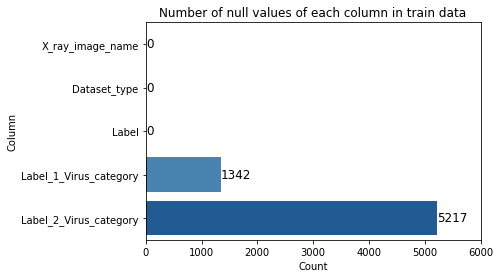

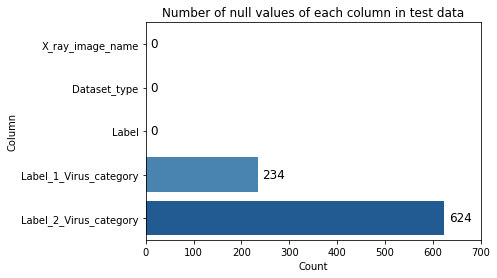

In [5]:
def count_plot_null_value(dataset, xticks):
    fig = plt.figure()
    if dataset == 'train':
        dataset_df = train_df
    else:
        dataset_df = test_df
    ax = sns.barplot(x=dataset_df.isnull().sum(), 
                     y=dataset_df.columns,
                     order=['X_ray_image_name', 'Dataset_type', 'Label', 'Label_1_Virus_category', 'Label_2_Virus_category'],
                     palette="Blues")
    ax.set_xticks(xticks)
    ax.set_ylabel('Column')
    ax.set_xlabel('Count')
    ax.set_title(f'Number of null values of each column in { dataset } data')

    # Add text to chart
    for p in ax.patches:
        ax.annotate(int(p.get_width()),
                    (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                    va='center',
                    size=12)
    plt.show()
        
count_plot_null_value('train', np.arange(0, 7000, 1000))
count_plot_null_value('test', np.arange(0, 750, 100))

In [6]:
# fill na
train_df.fillna('unknow', inplace=True)
test_df.fillna('unknow', inplace=True)

**Count value in Label column**

In [7]:
def count_plot_value_in_column(column, dataset, ax, order=None):
    ax = sns.countplot(y=column, 
                       data=dataset, 
                       palette='Blues',
                       ax=ax,
                       order=order)
    return ax

def add_annotate_to_chart(ax):
    for p in ax.patches:
        ax.annotate(int(p.get_width()),
                    (p.get_width() + 10, p.get_y() + p.get_height() / 2),
                    va='center',
                    size=12)

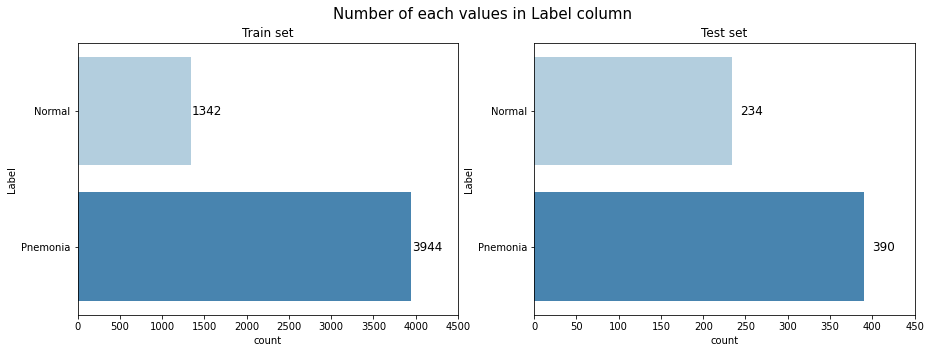

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Train set
ax = count_plot_value_in_column('Label', train_df, axs[0])
ax.set_xticks(np.arange(0, 5000, 500))
ax.set_title('Train set')
add_annotate_to_chart(ax)

# Test set
ax = count_plot_value_in_column('Label', test_df, axs[1])
ax.set_xticks(np.arange(0, 500, 50))
ax.set_title('Test set')
add_annotate_to_chart(ax)

fig.suptitle('Number of each values in Label column', size=15)
plt.show()

**Make sure that all normal cases go with unknow value in Label_1_Virus_category and Label_2_Virus_category**

In [9]:
train_normal = train_df[train_df.Label == 'Normal']
test_normal = test_df[test_df.Label == 'Normal']

train_normal_with_unknow = train_normal[(train_normal.Label_1_Virus_category == 'unknow') & (train_normal.Label_2_Virus_category == 'unknow')]
test_normal_with_unknow = test_normal[(test_normal.Label_1_Virus_category == 'unknow') & (test_normal.Label_2_Virus_category == 'unknow')]

total_normal_cases = train_normal.shape[0] + test_normal.shape[0]
total_normal_with_unknow_cases = train_normal_with_unknow.shape[0] + test_normal_with_unknow.shape[0]

print(f'Label = Normal: { total_normal_cases }')
print(f"Label = Normal & Label_1 = unknow & Label_2 = unknow: { total_normal_with_unknow_cases }")

assert total_normal_cases + total_normal_with_unknow_cases

Label = Normal: 1576
Label = Normal & Label_1 = unknow & Label_2 = unknow: 1576


**Count value in Label_1_Virus_category column**

In [10]:
train_pnemonia = train_df[~train_df.index.isin(train_normal.index)]
test_pnemonia = test_df[~test_df.index.isin(test_normal.index)]

assert train_pnemonia.shape[0] + train_normal.shape[0] == train_df.shape[0]
assert test_pnemonia.shape[0] + test_normal.shape[0] == test_df.shape[0]

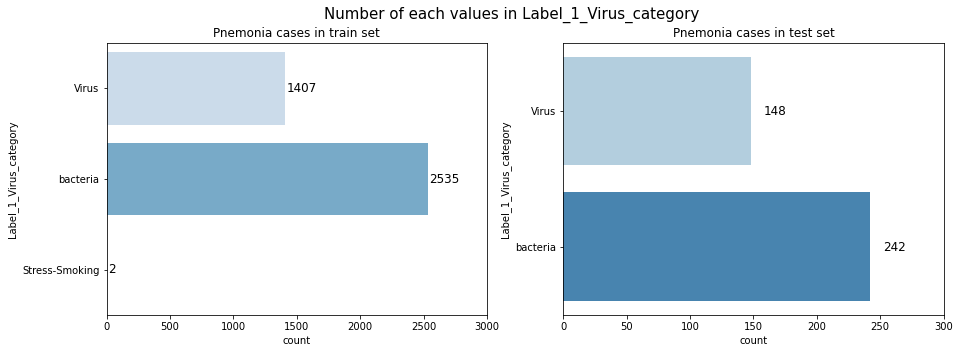

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Train pnemonia
ax = count_plot_value_in_column('Label_1_Virus_category', 
                                train_pnemonia, 
                                axs[0])
ax.set_xticks(np.arange(0, 3500, 500))
ax.set_title('Pnemonia cases in train set')
add_annotate_to_chart(ax)

# Test pnemonia
ax = count_plot_value_in_column('Label_1_Virus_category',
                                test_pnemonia,
                                axs[1])
ax.set_xticks(np.arange(0, 350, 50))
ax.set_title('Pnemonia cases in test set')
add_annotate_to_chart(ax)

fig.suptitle('Number of each values in Label_1_Virus_category', size=15)

plt.show()

**Count value in Label_2_Virus_category column**

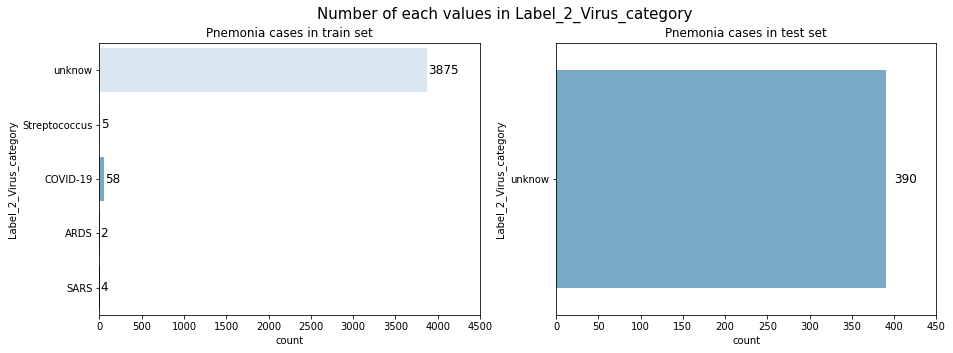

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Train pnemonia
ax = count_plot_value_in_column('Label_2_Virus_category', 
                                train_pnemonia, 
                                axs[0])
ax.set_xticks(np.arange(0, 5000, 500))
ax.set_title('Pnemonia cases in train set')
add_annotate_to_chart(ax)

# Test pnemonia 
ax = count_plot_value_in_column('Label_2_Virus_category', test_pnemonia, axs[1])
ax.set_xticks(np.arange(0, 500, 50))
ax.set_title('Pnemonia cases in test set')
add_annotate_to_chart(ax)

fig.suptitle('Number of each values in Label_2_Virus_category', size=15)

plt.show()

### Inference from charts
* We have 2 cases that is Pnemonia and Normal case. 
* Pnemonia cases is much more than Normal cases in both train set and test set.
* All Normal cases is labeled as unknow/null in Label_1_Virus_category and Label_2_Virus_category.
* All Pnemonia cases is labeled as bacteria, virus, stress-smoking and dont have any unknow/null value in Label_1_Virus_category in both train set and test set. 
* In train set, most of pnemonia case is labeled as unknow/null value (3875/3944).
* In test set, all pnemonia case is labels as unknow/null value.
* In Label_1_Virus_category, those value are different to much.
* In Label_2_Virus_category, if we remove all unknow value then we just have 69 sample.
* Thus we are going to construct a model which classifies Normal and Pnemonia cases.
* Cause the difference of Pnemonia and Normal cases so that we should use AUC or F1 score to evaluate the goodness of model.

# 3. Visualize image

**Plot random 6 images in train set**

In [13]:
assert os.path.exists(train_img_folder)
assert os.path.exists(test_img_folder)

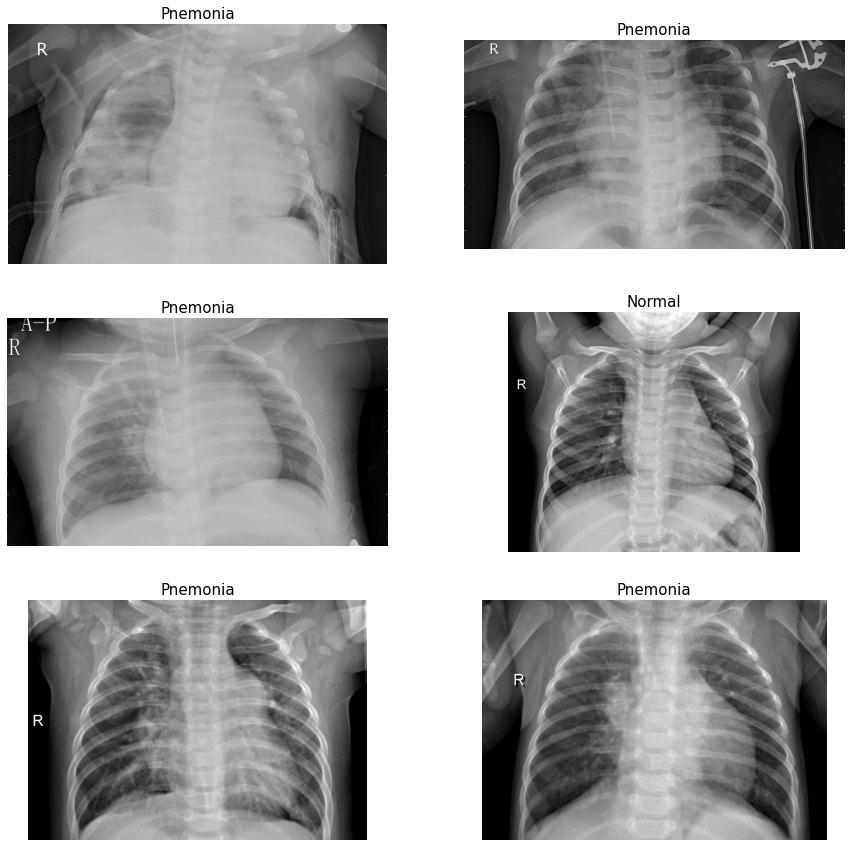

In [14]:
random_train_img = train_df.sample(6).reset_index(drop=True)

fig = plt.figure(figsize=(15, 15))
for i in range(6):
    ax = plt.subplot(3, 2, i+1)
    img_path = os.path.join(train_img_folder, random_train_img.loc[i, 'X_ray_image_name'])
    label = random_train_img.loc[i, 'Label']
    img = load_img(img_path)
    ax.axis('off')
    ax.set_title(label, size=15)
    ax.imshow(img)
    
plt.show()

## Image histogram
> An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image. It plots the number of pixels for each tonal value. By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance.

**Image histogram of 5 Normal cases**

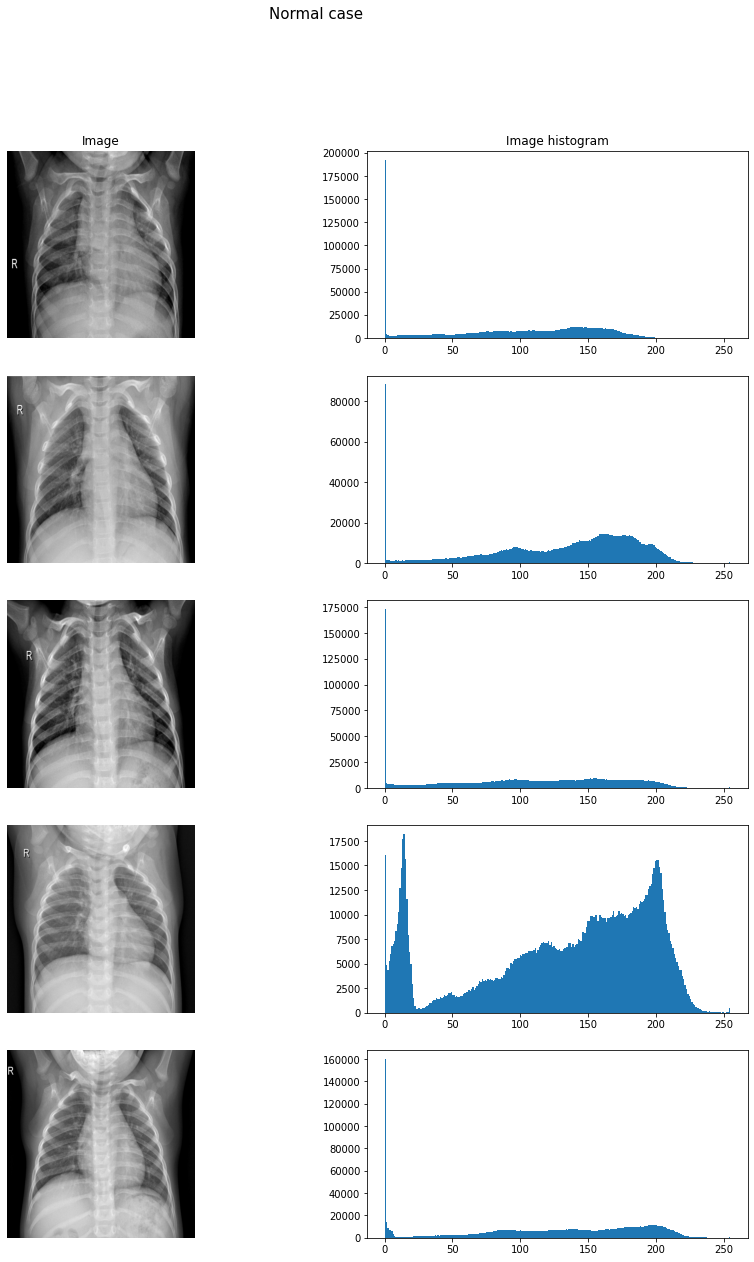

In [15]:
normal_case_img_name = train_df[train_df.Label == 'Normal'].X_ray_image_name[:5]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
for idx, img_name in enumerate(normal_case_img_name):
    # Plot image
    img_path = os.path.join(train_img_folder, img_name)
    img = load_img(img_path)
    img = img.resize((700, 700))
    axs[idx, 0].imshow(img)
    axs[idx, 0].axis('off')
    # Plot image histogram
    img_arr = img_to_array(img)
    axs[idx, 1].hist(img_arr.ravel(), 256)
    
axs[0, 0].set_title('Image')    
axs[0, 1].set_title('Image histogram')
fig.suptitle('Normal case', size = 15)
plt.show()

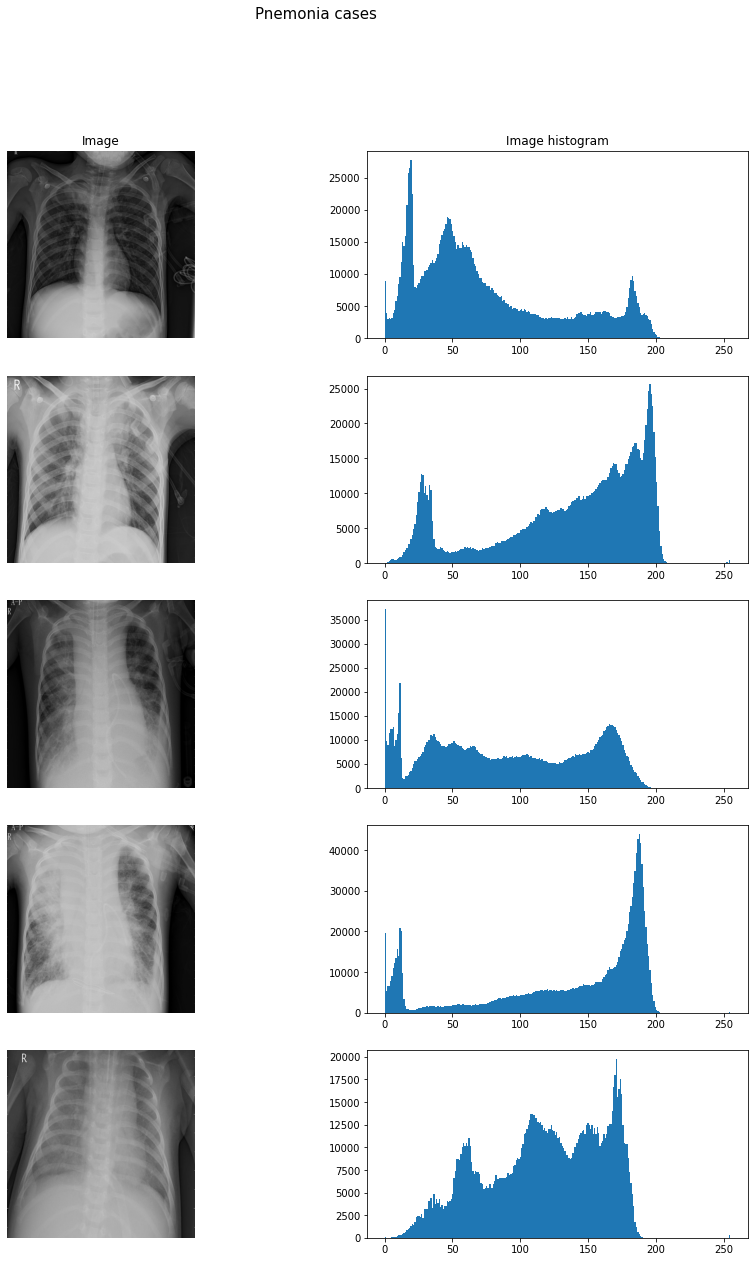

In [16]:
pnemonia_case_img_name = train_df[train_df.Label == 'Pnemonia'].X_ray_image_name[:5]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
for idx, img_name in enumerate(pnemonia_case_img_name):
    # Plot image
    img_path = os.path.join(train_img_folder, img_name)
    img = load_img(img_path)
    img = img.resize((700, 700))
    axs[idx, 0].imshow(img)
    axs[idx, 0].axis('off')
    # Plot image histogram
    img_arr = img_to_array(img)
    axs[idx, 1].hist(img_arr.ravel(), 256)

axs[0, 0].set_title('Image')
axs[0, 1].set_title('Image histogram')
fig.suptitle('Pnemonia cases', size=15)
plt.show()

# 4. Data augmentation

In [17]:
def load_img_path(quantity, dataset):
    if dataset == 'train':
        df = train_df
        folder = train_img_folder
    elif dataset == 'test':
        df = test_df
        folder = test_img_folder
    if quantity <= 0:
        return None
    img_names = df.X_ray_image_name[:quantity]
    img_paths = [os.path.join(folder, img_name) for img_name in img_names]
    return img_paths

def img_path_to_array(img_paths):
    img_arr = [img_to_array(load_img(img_path).resize((500, 500))) for img_path in tqdm(img_paths)]
    img_arr = np.array(img_arr)
    return img_arr

def show_img(img):
    plt.imshow(array_to_img(img))
    
def show_multi_img(img_arr):
    fig = plt.figure(figsize=(20,10))
    for i in range(len(img_arr)):
        plt.subplot(len(img_arr) / 4, 4, i+1)
        show_img(img_arr[i])
        plt.axis('off')

In [18]:
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.1, 1.2),
                              horizontal_flip=True,
                              zoom_range=[0.75, 1])
test_datagen = ImageDataGenerator()

**Plot images after augmentation**

In [19]:
img_paths = load_img_path(100, 'train')
img_arr = img_path_to_array(img_paths)

100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


In [20]:
aug_imgs = train_datagen.flow(img_arr ,batch_size=8)
print(f'Number of batches: { len(aug_imgs) }')

Number of batches: 13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


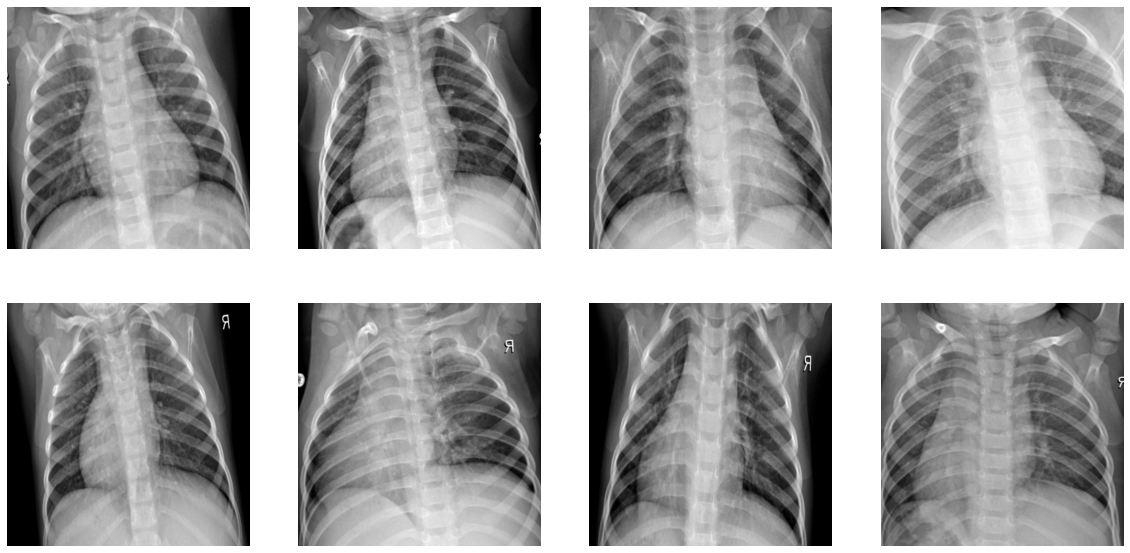

In [21]:
show_multi_img(aug_imgs[0])

# 5. Prepare data

In [22]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [23]:
train_batches = train_datagen.flow_from_dataframe(train_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

valid_batches = test_datagen.flow_from_dataframe(valid_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

test_batches = test_datagen.flow_from_dataframe(test_df,
                                            directory=test_img_folder,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=8,
                                            shuffle=False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [24]:
print(f'Label encode: { train_batches.class_indices }')

Label encode: {'Normal': 0, 'Pnemonia': 1}


In [25]:
train_batches_series = pd.Series(train_batches.classes)
valid_batches_series = pd.Series(valid_batches.classes)

print(f'Value count in train_batches: \n{ train_batches_series.value_counts() }')
print(f'Value count in valid_batches: \n{ valid_batches_series.value_counts() }')

Value count in train_batches: 
1    3169
0    1059
dtype: int64
Value count in valid_batches: 
1    775
0    283
dtype: int64


# 6. Build AlexNet

In [26]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
create_dir('models')

**Preprocessing layers**

In [27]:
# When export model, these preprocessing layers will be saved along with the rest of model
resize_and_rescale = Sequential([
    Resizing(227, 227),
    Rescaling(1./255)
])

**Define metrics used for all models**

In [28]:
metrics = [TruePositives(name='TP'),
           TrueNegatives(name='TN'),
           FalsePositives(name='FP'),
           FalseNegatives(name='FN'),
           AUC(curve='PR', name='AUC')]

## 6.1 AlexNet

**Define model architecture**

In [29]:
lamb = 0.9

model = Sequential([
    # Preprocessing layer
    resize_and_rescale,
    
    InputLayer((227, 227, 3)),
    
    # 1st layer
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', kernel_regularizer=l2(lamb), name='conv1'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    BatchNormalization(),
    
    # 2nd layer
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    BatchNormalization(),
    
    # 3rd layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv3'),
    BatchNormalization(),
    
    # 4th layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv4'),
    BatchNormalization(),
    
    # 5th layer
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    BatchNormalization(),
    
    # Flatten
    Flatten(),
    
    # 6th layer
    Dense(units=4096, activation='relu'),
    Dropout(0.5),
    
    # 7th layer
    Dense(units=4096, activation='relu'),
    Dropout(0.5),
    
    # 8th layer (output)
    Dense(units=1, activation='sigmoid')
], name='AlexNet')

In [30]:
#Create folder contains model's files
model_dir = 'models/alexnet'
model_file = 'best_alexnet.hdf5'
create_dir(model_dir)

checkpoint = ModelCheckpoint(os.path.join(model_dir, model_file),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30,
                               verbose=1,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), 
                              patience=7, min_delta=1e-3, verbose=1, min_lr=1e-7)

In [31]:
# Initialize TensorBoard
log_dir = 'models/alexnet/logs' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 6.2 Train AlexNet

In [32]:
batch_size = 128
epochs = 200
lr = 1e-3

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=metrics)

training_time_start = datetime.datetime.now()

history = model.fit(train_batches,
                                epochs=epochs,
                                verbose=1,
                                callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_callback],
                                validation_data=valid_batches,
                                steps_per_epoch=len(train_batches),
                                validation_steps=len(valid_batches))

training_time_end = datetime.datetime.now()

Epoch 1/200
34/34 [==============================] - 193s 5s/step - loss: 639.5454 - TP: 1338.2000 - TN: 150.1429 - FP: 428.5429 - FN: 372.8286 - AUC: 0.7578 - val_loss: 45.4131 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.7318

Epoch 00001: val_loss improved from inf to 45.41310, saving model to models/alexnet/best_alexnet.hdf5
Epoch 2/200
34/34 [==============================] - 137s 4s/step - loss: 25.8155 - TP: 1629.6857 - TN: 29.3714 - FP: 536.4286 - FN: 55.2571 - AUC: 0.8094 - val_loss: 4.4548 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.7325

Epoch 00002: val_loss improved from 45.41310 to 4.45485, saving model to models/alexnet/best_alexnet.hdf5
Epoch 3/200
34/34 [==============================] - 132s 4s/step - loss: 3.2207 - TP: 1607.9429 - TN: 69.4000 - FP: 482.2000 - FN: 59.3143 - AUC: 0.8654 - val_loss: 1.6227 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 

In [33]:
total_training_seconds = (training_time_end - training_time_start).seconds
print('Total training time: ', str(datetime.timedelta(seconds=total_training_seconds)))

Total training time:  4:56:36


## 6.3 Plot learning curve

In [34]:
history_df = pd.DataFrame(history.history)

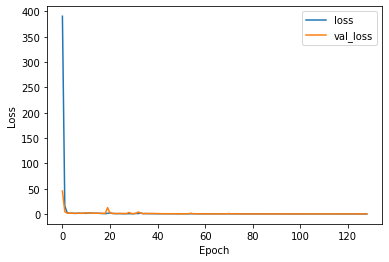

In [35]:
history_df[['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

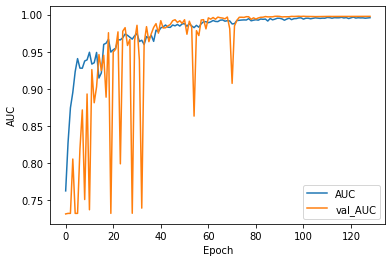

In [36]:
history_df[['AUC', 'val_AUC']].plot()
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.show()

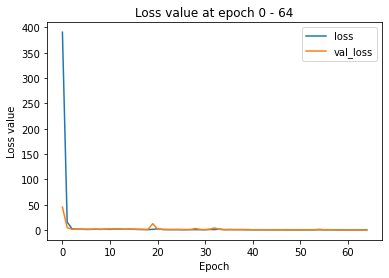

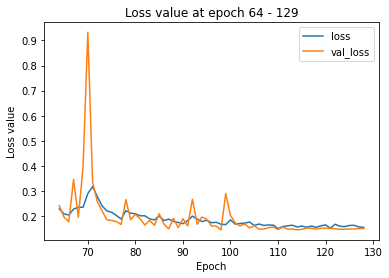

In [37]:
num_of_epochs = history_df.shape[0]
half_epoch = int(num_of_epochs / 2)

first_half_history = history_df.loc[:half_epoch]
first_title = f'Loss value at epoch 0 - { half_epoch }'

last_half_history = history_df.loc[half_epoch:len(history_df)]
last_title = f'Loss value at epoch { half_epoch } - { len(history_df) }'

hists = [first_half_history, last_half_history]
titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['loss', 'val_loss']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss value')
    ax.set_title(titles[i])
plt.show()

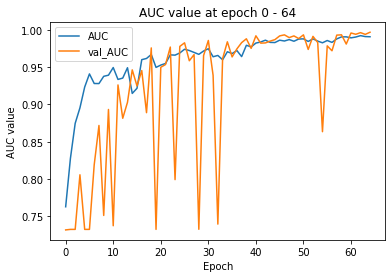

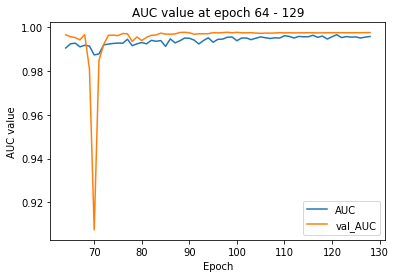

In [38]:
first_title = f'AUC value at epoch 0 - { half_epoch }'
last_title = f'AUC value at epoch { half_epoch } - { len(history_df) }'

titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['AUC', 'val_AUC']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC value')
    ax.set_title(titles[i])
plt.show()

## 6.4 Evaluate

In [39]:
evaluate = model.evaluate(test_batches, verbose=1)

78/78 [==============================] - 12s 148ms/step - loss: 0.4053 - TP: 375.0000 - TN: 175.0000 - FP: 59.0000 - FN: 15.0000 - AUC: 0.9555


In [40]:
loss, tp, fp, tn, fn, auc = evaluate[0], evaluate[1], evaluate[2], evaluate[3], evaluate[4], evaluate[5]
print(f'Test loss: { loss }')
print(f'True positive: { tp }')
print(f'False positive: { fp }')
print(f'True negative: { tn }')
print(f'False negative: { fn }')
print('AUC: %.2f' % auc)

Test loss: 0.4052698016166687
True positive: 375.0
False positive: 175.0
True negative: 59.0
False negative: 15.0
AUC: 0.96
